1. Pull the images csv from callisto
2. Get the list of HPA genes with cell-cycle plots
3. Put those into a dataset folder
4. Run the main file to clean up and segment the data (are there masks already?)

## Ensure Kernel is data-prep until the mask processing step is complete. If using implicit, just rerun this first section.

In [4]:
%reload_ext autoreload
%autoreload 2

import torch
import os
from pathlib import Path
import csv
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = Path('/data/ishang/HPA-CC-dataset/')
NAME = "512_min_max"
ARCHIVE = "/data/HPA-IF-images/"
USER = "ishangaur"
TARGET = {
    "username": "ishang",
    "hostname": "sscb-a100.scilifelab.se",
}

In [5]:
os.makedirs(DATA_DIR, exist_ok=True)
print(f"{str(DATA_DIR)} has {len(list(DATA_DIR.iterdir()))} files")


/data/ishang/HPA-CC-dataset has 114 files


In [6]:
df = pd.read_csv(Path.cwd() / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


,filename,jpg_prefix,if_plate_id,position,sample,status,Image status name,locations,staining characteristics,unspecific,...,z_pos,Experiment state,Ab state,Max tpm,Finished in genes,Protocol,Gene reliability (in release),Gene reliability (lims),Cell count,well_location_predictions_all
0,/archive/1/1_A1_1_,https://lims.proteinatlas.org/images/992/1_A1_1_,1,A1,1,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,7.0,NaN
1,/archive/1/1_A1_2_,https://lims.proteinatlas.org/images/992/1_A1_2_,1,A1,2,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,6.0,NaN
2,/archive/1/1_A3_1_,https://lims.proteinatlas.org/images/2899/1_A3_1_,1,A3,1,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,4.0,NaN
3,/archive/1/1_A3_2_,https://lims.proteinatlas.org/images/2899/1_A3_2_,1,A3,2,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,6.0,NaN
4,/archive/1/1_A6_1_,https://lims.proteinatlas.org/images/609/1_A6_1_,1,A6,1,35,Annotated / Proteinatlas,"Endoplasmic reticulum,Nuclear membrane",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,81.38,ENSG00000102119,PFA,Enhanced,Enhanced,5.0,NaN


In [7]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
# ccd_rows = df["gene_names"].isin(CCD_prots)
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
# ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"]) & df["Gene reliability (lims)"].isin(["Approved", "Enhanced"])
# ccd_df = df[ccd_rows][["filename", "jpg_prefix", "if_plate_id", "position", "sample", "gene_names",
#                        'status', 'Image status name', 'locations', 'staining characteristics', 'unspecific',
#                        'antibody', "atlas_name", "Cell count", 'Gene reliability (in release)', 'Gene reliability (lims)']]
ccd_df = df[ccd_rows][["filename", "jpg_prefix", "ensembl_ids", "if_plate_id", "position", "sample", "gene_names",
                       'locations', 'antibody', "atlas_name", "Cell count"]]
print(f"Missing proteins, {set(CCD_prots) - set(ccd_df['gene_names'])}")
ccd_df

Missing proteins, {'TTC21B'}


,filename,jpg_prefix,ensembl_ids,if_plate_id,position,sample,gene_names,locations,antibody,atlas_name,Cell count
6071,/archive/91/91_H6_1_,https://lims.proteinatlas.org/images/8419/91_H...,ENSG00000156970,91,H6,1,BUB1B,Cytosol,HPA008419,U2OS,10.0
6072,/archive/91/91_H6_2_,https://lims.proteinatlas.org/images/8419/91_H...,ENSG00000156970,91,H6,2,BUB1B,Cytosol,HPA008419,U2OS,10.0
9033,/archive/148/148_F6_1_,https://lims.proteinatlas.org/images/21501/148...,ENSG00000162999,148,F6,1,DUSP19,Nucleoplasm,HPA021501,U2OS,9.0
9034,/archive/148/148_F6_2_,https://lims.proteinatlas.org/images/21501/148...,ENSG00000162999,148,F6,2,DUSP19,Nucleoplasm,HPA021501,U2OS,6.0
14254,/archive/247/247_C1_1_,https://lims.proteinatlas.org/images/18169/247...,ENSG00000105173,247,C1,1,CCNE1,Nucleoplasm,HPA018169,U2OS,7.0
14255,/archive/247/247_C1_2_,https://lims.proteinatlas.org/images/18169/247...,ENSG00000105173,247,C1,2,CCNE1,Nucleoplasm,HPA018169,U2OS,9.0
29928,/archive/581/581_B5_1_,https://lims.proteinatlas.org/images/38448/581...,ENSG00000019144,581,B5,1,PHLDB1,"Cytosol,Vesicles",HPA038448,U2OS,15.0
29929,/archive/581/581_B5_3_,https://lims.proteinatlas.org/images/38448/581...,ENSG00000019144,581,B5,3,PHLDB1,"Cytosol,Vesicles",HPA038448,U2OS,12.0
30008,/archive/582/582_D9_1_,https://lims.proteinatlas.org/images/36656/582...,ENSG00000109814,582,D9,1,UGDH,Nucleoplasm,HPA036656,U2OS,9.0
30009,/archive/582/582_D9_2_,https://lims.proteinatlas.org/images/36656/582...,ENSG00000109814,582,D9,2,UGDH,Nucleoplasm,HPA036656,U2OS,10.0


# Dataset Preparation

In [12]:
# remove /archive/ from all rows of "filename" column in ccd_df
print(ccd_df["filename"].iloc[0])
ccd_df["filename"] = ccd_df["filename"].apply(lambda x: x.replace("/archive/", ""))
print(ccd_df["filename"].iloc[0])

# now add a *.png to each so we glob all the images in the folder
ccd_df["filename"] = ccd_df["filename"].apply(lambda x: x + "*.png")
ccd_df["filename"].iloc[0]

/archive/91/91_H6_1_
91/91_H6_1_


'91/91_H6_1_*.png'

In [13]:
# form an scp command to copy all the images to the data dir
# the filenames need to be in the form ARCHIVE/{filename1,filename2,...}
file_endings = ["blue", "green", "red", "yellow"]
images = []
for filename in ccd_df["filename"]:
    for ending in file_endings:
        images.append(filename.replace("*", ending))


In [14]:
master_socket = f"SSHSOCKET=~/.ssh/{TARGET['username']}@{TARGET['hostname']}"
master_ssh = f"ssh -M -f -N -o ControlPath=$SSHSOCKET {TARGET['username']}@{TARGET['hostname']}"
file_transfer = f"scp -o ControlPath=$SSHSOCKET {ARCHIVE}{'{' + ','.join(images)+'}'} {TARGET['username']}@{TARGET['hostname']}:{DATA_DIR}"
close_master = f"ssh -S $SSHSOCKET -O exit {TARGET['username']}@{TARGET['hostname']}"

print("Run the following commands from the machine with the data:")
print(master_socket)
print(master_ssh)
print(file_transfer)
print(close_master)

Run the following commands from the machine with the data:
SSHSOCKET=~/.ssh/ishang@sscb-a100.scilifelab.se
ssh -M -f -N -o ControlPath=$SSHSOCKET ishang@sscb-a100.scilifelab.se
scp -o ControlPath=$SSHSOCKET /data/HPA-IF-images/{91/91_H6_1_blue.png,91/91_H6_1_green.png,91/91_H6_1_red.png,91/91_H6_1_yellow.png,91/91_H6_2_blue.png,91/91_H6_2_green.png,91/91_H6_2_red.png,91/91_H6_2_yellow.png,148/148_F6_1_blue.png,148/148_F6_1_green.png,148/148_F6_1_red.png,148/148_F6_1_yellow.png,148/148_F6_2_blue.png,148/148_F6_2_green.png,148/148_F6_2_red.png,148/148_F6_2_yellow.png,247/247_C1_1_blue.png,247/247_C1_1_green.png,247/247_C1_1_red.png,247/247_C1_1_yellow.png,247/247_C1_2_blue.png,247/247_C1_2_green.png,247/247_C1_2_red.png,247/247_C1_2_yellow.png,581/581_B5_1_blue.png,581/581_B5_1_green.png,581/581_B5_1_red.png,581/581_B5_1_yellow.png,581/581_B5_3_blue.png,581/581_B5_3_green.png,581/581_B5_3_red.png,581/581_B5_3_yellow.png,582/582_D9_1_blue.png,582/582_D9_1_green.png,582/582_D9_1_red.png,58

In [15]:
# check that the number of files in the data dir is the same as the number of images
print(f"{str(DATA_DIR)} has {len(list(DATA_DIR.iterdir()))} files, expected {len(ccd_df)*4}")

/data/ishang/HPA-CC-dataset has 110 files, expected 240


In [16]:
# make folders for each well_positions combination, and move the images into them
# in other words, these are all images with the same prefix: {if_plate_id}_{position}_{sample}_{channel}.png
# we want to move them into a folder called {if_plate_id}_{position}
try:
    for index, row in ccd_df.iterrows():
        folder_name = "_".join([str(row["if_plate_id"]), str(row["position"])])
        sample = str(row["sample"])
        os.makedirs(DATA_DIR / folder_name, exist_ok=True)
        for channel in file_endings:
            image_name = folder_name + f"_{sample}_{channel}.png"
            os.rename(DATA_DIR / image_name, DATA_DIR / folder_name / image_name)
except FileNotFoundError:
    print("FileNotFoundError: probably because the files have already been moved")

# check that the number of files in the data dir is the same as the number of images and that no images remain
print(f"{str(DATA_DIR)} has {len(list(DATA_DIR.iterdir()))} files")
total_images = 0
for folder in DATA_DIR.iterdir():
    if not folder.is_dir():
        continue
    total_images += len(list(folder.iterdir()))
print(f"{str(DATA_DIR)} has {total_images} images")

FileNotFoundError: probably because the files have already been moved
/data/ishang/HPA-CC-dataset has 110 files
/data/ishang/HPA-CC-dataset has 602 images


In [17]:
# write ccd_df to file
ccd_df.to_csv(DATA_DIR / "ccd_df.csv", index=False)

# Dataset Image Processing

At this point we need to make an hpa_cc_config.py config file like the non-well fucci config

In [18]:
!python main.py --data_dir $DATA_DIR --config hpa_cc_config.py --name $NAME --image_mask_cache --rebuild

Using device cuda:7
Caching composite images and getting segmentation masks
Overwriting image path index at: /data/ishang/HPA-CC-dataset/data-folder.txt
Creating image path index at: /data/ishang/HPA-CC-dataset/data-folder.txt
Number of target paths found: 31
Traceback (most recent call last):
  File "/home/ishang/HPA-embedding/main.py", line 187, in <module>
    segmentator = segmentator_setup(multi_channel_model, device)
  File "/home/ishang/HPA-embedding/pipeline.py", line 72, in segmentator_setup
    raise ValueError(f"HPA Cell Segmentator is not compatible with torch >= 1.10.0.\nTorch {torch.__version__} detected. Are you using the 'data-prep' conda environment?")
ValueError: HPA Cell Segmentator is not compatible with torch >= 1.10.0.
Torch 2.0.1 detected. Are you using the 'data-prep' conda environment?


## Switch to implicit kernel!

In [ ]:
!python main.py --data_dir $DATA_DIR --config hpa_cc_config.py --name 512_min_max --clean_masks --normalize --single_cell --rebuild

Using device cuda:7
Cleaning masks
Cleaning masks: 100%|███████████████████████████| 30/30 [00:56<00:00,  1.87s/it]
Fraction removed: 0.0
Total cells removed: 0
Total cells remaining: 953
Normalizing images
Using cleaned images
Normalizing images: 100%|███████████████████████| 30/30 [00:08<00:00,  3.66it/s]
Cropping single cell images
/data/ishang/HPA-CC-dataset/index_clean_rm_1000_norm_min_max.csv
Resizing images: 100%|██████████████████████████| 30/30 [00:14<00:00,  2.10it/s]


In [ ]:
# split the last part of the sample_name path on the if_plate_id, position, and sample
index_df = pd.read_csv(DATA_DIR / f"index_{NAME}.csv")
for index, row in index_df.iterrows():
    well_name = row["sample_name"]
    if_plate_id, position = well_name.split("/")[-1].split("_")
    index_df.at[index, "if_plate_id"] = if_plate_id
    index_df.at[index, "position"] = position

index_df["if_plate_id"] = index_df["if_plate_id"].astype(str)
index_df["position"] = index_df["position"].astype(str)

ccd_df["if_plate_id"] = ccd_df["if_plate_id"].astype(str)
ccd_df["position"] = ccd_df["position"].astype(str)

# filter the index.csv by protein-antibody pairs and save new index.csv files for each
for i in range(len(CCD_prots)):
    prot = CCD_prots[i]
    print(f"Protein {prot}")
    antibodies = ccd_df[ccd_df["gene_names"] == prot]["antibody"].unique()
    for antibody in antibodies:
        print(f"\tAntibody {antibody}")
        rows = (ccd_df["gene_names"] == prot) & (ccd_df["antibody"] == antibody)
        prot_ant_df = ccd_df[rows][["if_plate_id", "position", "sample"]]
        print(f"\t\tFound {len(prot_ant_df)} images for protein {prot} and antibody {antibody}")
        plate_id, pos = prot_ant_df["if_plate_id"].iloc[0], prot_ant_df["position"].iloc[0]
        prot_ant_index_df = index_df[index_df["if_plate_id"] == plate_id][index_df["position"] == pos]
        prot_ant_index_df = prot_ant_index_df[["sample_name", "image_path", "cell_mask_path", "nuclei_mask_path"]]
        index_file_name = f"index_{NAME}_{prot}_{antibody}.csv"
        prot_ant_index_df.to_csv(DATA_DIR / index_file_name, index=False)
        print(f"\t\tSaved {index_file_name} with {len(prot_ant_index_df)} rows")

Protein DUSP19
	Antibody HPA021501
		Found 2 images for protein DUSP19 and antibody HPA021501
		Saved index_512_min_max_DUSP19_HPA021501.csv with 1 rows
Protein DUSP18
	Antibody HPA051349
		Found 2 images for protein DUSP18 and antibody HPA051349
		Saved index_512_min_max_DUSP18_HPA051349.csv with 1 rows
Protein PAPSS1
	Antibody HPA049781
		Found 2 images for protein PAPSS1 and antibody HPA049781
		Saved index_512_min_max_PAPSS1_HPA049781.csv with 1 rows
Protein N6AMT1
	Antibody HPA059242
		Found 2 images for protein N6AMT1 and antibody HPA059242
		Saved index_512_min_max_N6AMT1_HPA059242.csv with 1 rows
Protein PHLDB1
	Antibody HPA038448
		Found 2 images for protein PHLDB1 and antibody HPA038448
		Saved index_512_min_max_PHLDB1_HPA038448.csv with 1 rows
Protein FLI1
	Antibody HPA073099
		Found 2 images for protein FLI1 and antibody HPA073099
		Saved index_512_min_max_FLI1_HPA073099.csv with 1 rows
Protein TTC21B
Protein PC
	Antibody HPA043922
		Found 2 images for protein PC and antibo

/tmp/ipykernel_1644965/68560989.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prot_ant_index_df = index_df[index_df["if_plate_id"] == plate_id][index_df["position"] == pos]


# CC Inference

In [2]:
from models import PseudoRegressorLit
from hpa_dino import HPA_DINO
from data import CellImageDataset
from utils import get_intensity_metrics
import pickle as pkl
from utils import get_images_percentiles

In [6]:
log_dirs_home = Path("/data/ishang/pseudotime_pred/")
# original large model on normalized images
# checkpoint_hash = "r2z2n8ap"
# concat = False
# well = False
# chamber and tile trained small model
# checkpoint_hash = "jv6n44jc"
# concat = True
# well = False
# chamber trained small model
# checkpoint_hash = "i2v4ueke"
# concat = True
# well = False
# all trained model, with well intensities and concat
# checkpoint_hash = "on08u1fc"
# concat = True
# well = True
# model trained on tile and chamber
# checkpoint_hash = "24jh7g80"
# checkpoint_hash = "wwzdewqp"
# checkpoint_hash = "nlr3fa5k" # 80/20
# concat = True
# well = True
# model trained only on the chamber dataset
# checkpoint_hash = "222lb9ox"
# checkpoint_hash = "vvepu5m7"
# concat = True
# well = True
# model trained only on the tile dataset
checkpoint_hash = "8ud1u6y4"
concat = True
well = True

chkpt_dir_pattern = f"{log_dirs_home}/*/*/*-{checkpoint_hash}/"
checkpoint_folder = glob(chkpt_dir_pattern)
if len(checkpoint_folder) > 1:
    raise ValueError(f"Multiple possible checkpoints found: {checkpoint_folder}")
if len(checkpoint_folder) == 0:
    raise ValueError(f"No checkpoint found for glob pattern: {chkpt_dir_pattern}")
models_folder = Path(checkpoint_folder[0]).parent.parent / "lightning_logs"
models_list = list(models_folder.iterdir())
models_list.sort()
# the elements should be ###-##.ckpt, 'epoch=###.ckpt', and 'last.ckpt'
checkpoint = models_list[0]
if not checkpoint.exists():
    raise ValueError(f"Checkpoint path {checkpoint} does not exist")

print(f"Loading {checkpoint}")
cls_to_pseudotime = PseudoRegressorLit.load_from_checkpoint(checkpoint)
print(cls_to_pseudotime.device)

Loading /data/ishang/pseudotime_pred/pseudo_dino_regressor_2023_10_11_07_30/lightning_logs/371-0.03.ckpt
cuda:0


In [9]:
# load HPA Dino Model for Inference
imsize = 512
batch_size = 32
dino = HPA_DINO(imsize, 100)

config['model']['arch'] vit_base in vits
loaded /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth
Pretrained weights found at /data/ishang/HPA_single_cells_data/HPA_single_cell_model_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [10]:
from pipeline import load_index_paths
prot_ant_int_ps = {}
cls_tokens = []
pseudotimes = []
for prot in CCD_prots:
    antibodies = ccd_df[ccd_df["gene_names"] == prot]["antibody"].unique()
    for antibody in antibodies:
        print(prot, antibody)
        dataset = CellImageDataset(DATA_DIR / f"index_{NAME}_{prot}_{antibody}.csv", channel_colors=["pure_blue", "pure_red", "pure_green"], batch_size=batch_size)

        image_paths, cell_mask_paths, nuclei_mask_paths = load_index_paths(DATA_DIR / f"index_{NAME}_{prot}_{antibody}.csv")
        print(len(image_paths)) ########## PRINT
        images, cell_masks, nuclei_masks = [], [], []
        for image_path, cell_mask_path, nuclei_mask_path in zip(image_paths, cell_mask_paths, nuclei_mask_paths):
            images.append(torch.load(image_path))
            cell_masks.append(torch.load(cell_mask_path))
            nuclei_masks.append(torch.load(nuclei_mask_path))
        images = torch.concatenate(images)
        cell_masks = torch.concatenate(cell_masks)
        nuclei_masks = torch.concatenate(nuclei_masks)

        intensity_sums, nuclear_intensity_sums, cell_pixel_ct, nucleus_pixel_ct = get_intensity_metrics(
            images, cell_masks, nuclei_masks
        )
        print(intensity_sums.shape) ########## PRINT

        log_mean_intensity = torch.log10(intensity_sums / cell_pixel_ct)
        nuc_log_mean_intensity = torch.log10(nuclear_intensity_sums / nucleus_pixel_ct)
        cyto_log_mean_intensity = torch.log10((intensity_sums - nuclear_intensity_sums) / (cell_pixel_ct - nucleus_pixel_ct))
        log_intensity = torch.log10(intensity_sums)
        mean_intensity = intensity_sums / cell_pixel_ct

        # prep input cls token to regressor
        if not concat:
            cls = dino.predict_cls_dataset(dataset).detach().to(cls_to_pseudotime.device)
        else:
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
            cls = []
            for batch in iter(dataloader):
                cls.append(dino.predict_cls_ref_concat(batch[:, :2]).detach().to(cls_to_pseudotime.device))
            cls = torch.cat(cls, dim=0)
        if well:
            resolution = 6 # bit
            buckets = 2 ** resolution
            eval_percentiles = np.array(list(range(0, buckets, 1))) / (buckets - 1) * 100

            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
            dataset_images = dataset[:]
            values, percentiles_used = get_images_percentiles(dataset_images[:, :2].detach().cpu().numpy(), percentiles=eval_percentiles, non_zero=True)
            values = torch.tensor(values).flatten()
            percentiles = torch.tensor(values)
            percentiles = torch.tile(percentiles, (cls.shape[0], 1))
            cls = torch.cat([cls, percentiles.to(cls.device)], dim=1)

        cls_tokens.append(torch.clone(cls.detach().cpu()))
        pseudotime = cls_to_pseudotime(cls).detach()
        pseudotime = pseudotime.remainder(2 * torch.pi) / (2 * torch.pi)
        pseudotimes.append(torch.clone(pseudotime.cpu()))
        print(len(pseudotime))

        prot_ant_int_ps[(prot, antibody)] = {
            "pseudotime": pseudotime,
            "intensity_sums": intensity_sums,
            "non_zero_cts": cell_pixel_ct,
            "nuc_pixel_cts": nucleus_pixel_ct,
            "log_mean_intensity": log_mean_intensity,
            "nuc_log_mean_intensity": nuc_log_mean_intensity,
            "cyto_log_mean_intensity": cyto_log_mean_intensity,
            "log_intensity": log_intensity,
            "mean_intensity": mean_intensity
        }

cls_tokens = torch.cat(cls_tokens, dim=0)
torch.save(cls_tokens, DATA_DIR / f"ref_cls_tokens_{checkpoint_hash}.pt")

pseudotimes = torch.cat(pseudotimes, dim=0)
torch.save(pseudotimes, DATA_DIR / f"pseudotimes_{checkpoint_hash}.pt")

with open(DATA_DIR / f"prot_ant_ps_stats_{checkpoint_hash}.pkl", "wb") as f:
    pkl.dump(prot_ant_int_ps, f)

DUSP19 HPA021501


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 22.49it/s]

Loaded 25 images from 1 files.
1



Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 25.34it/s]

torch.Size([25, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


25
DUSP18 HPA051349


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]


Loaded 37 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 19.41it/s]


torch.Size([37, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


37
PAPSS1 HPA049781


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


Loaded 32 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


torch.Size([32, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


32
N6AMT1 HPA059242


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]


Loaded 22 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 26.52it/s]

torch.Size([22, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


22
PHLDB1 HPA038448


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

Loaded 33 images from 1 files.
1



Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


torch.Size([33, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


33
FLI1 HPA073099


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 19.91it/s]


Loaded 19 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


torch.Size([19, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


19
PC HPA043922


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


Loaded 33 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 42.65it/s]


torch.Size([33, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


33
PC CAB033742


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Loaded 38 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 38.03it/s]


torch.Size([38, 4])
Calculating well pixel percentiles
38
PC HPA058765


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]

Loaded 41 images from 1 files.
1



Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]


torch.Size([41, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


41
UGDH HPA036656


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Loaded 27 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 27.17it/s]


torch.Size([27, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


27
UGDH CAB034444


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Loaded 25 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 27.48it/s]

torch.Size([25, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


25
ORC6 HPA072587


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


Loaded 34 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 35.03it/s]


torch.Size([34, 4])
Calculating well pixel percentiles
34
ZNF32 HPA059640


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


Loaded 33 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 39.10it/s]


torch.Size([33, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


33
ZNF32 HPA039148


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Loaded 43 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 30.57it/s]


torch.Size([43, 4])
Calculating well pixel percentiles
43
CCNE1 HPA018169


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]


Loaded 24 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 28.91it/s]

torch.Size([24, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


24
CCNE1 CAB000308


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


Loaded 27 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 26.41it/s]

torch.Size([27, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


27
CCNB1 CAB000115


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


Loaded 26 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


torch.Size([26, 4])
Calculating well pixel percentiles
26
CCNB1 HPA030741


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 24.88it/s]


Loaded 19 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 36.39it/s]

torch.Size([19, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


19
CCNB1 HPA061448


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


Loaded 35 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 35.78it/s]


torch.Size([35, 4])
Calculating well pixel percentiles
35
AURKB HPA037708


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]

Loaded 29 images from 1 files.
1



Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


torch.Size([29, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


29
BUB1B HPA008419


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 15.70it/s]


Loaded 28 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 26.97it/s]


torch.Size([28, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


28
DPH2 HPA045796


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Loaded 34 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 41.14it/s]


torch.Size([34, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


34
GMNN CAB011458


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 12.34it/s]


Loaded 38 images from 1 files.
1


Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 39.44it/s]


torch.Size([38, 4])
Calculating well pixel percentiles
38
GMNN CAB047328


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

Loaded 38 images from 1 files.
1



Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 38.87it/s]


torch.Size([38, 4])
Calculating well pixel percentiles
38
GMNN CAB047327


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

Loaded 36 images from 1 files.
1



Computing mean intensities: 100%|██████████| 2/2 [00:00<00:00, 37.39it/s]


torch.Size([36, 4])
Calculating well pixel percentiles
36
GMNN HPA049977


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


Loaded 23 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 39.84it/s]

torch.Size([23, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


23
GMNN HPA054597


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


Loaded 28 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


torch.Size([28, 4])
Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


28
CDT1 HPA017224


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]


Loaded 21 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 33.00it/s]


torch.Size([21, 4])
Calculating well pixel percentiles
21
ANLN HPA050556


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 25.82it/s]


Loaded 17 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 53.46it/s]

torch.Size([17, 4])


Calculating well pixel percentiles


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


17
ANLN CAB068175


Loading dataset images: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s]


Loaded 28 images from 1 files.
1


Computing mean intensities: 100%|██████████| 1/1 [00:00<00:00, 25.13it/s]

torch.Size([28, 4])


Calculating well pixel percentiles
28


/tmp/ipykernel_2934690/3294553667.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  percentiles = torch.tensor(values)


# Plotting/Analysis!

Figures to compare:

https://www.nature.com/articles/s41586-021-03232-9/figures/3

https://www.nature.com/articles/s41586-021-03232-9/figures/13

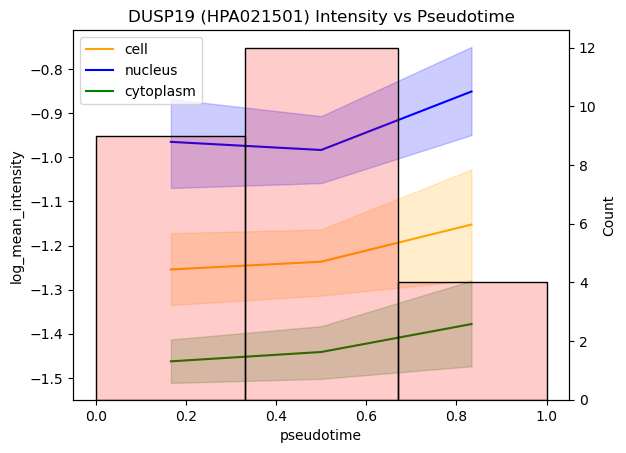

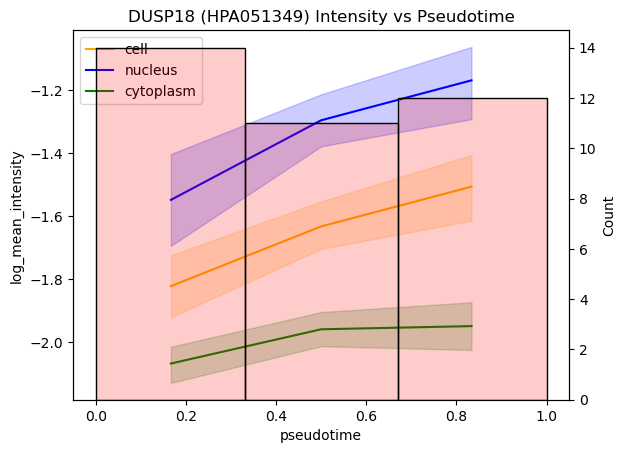

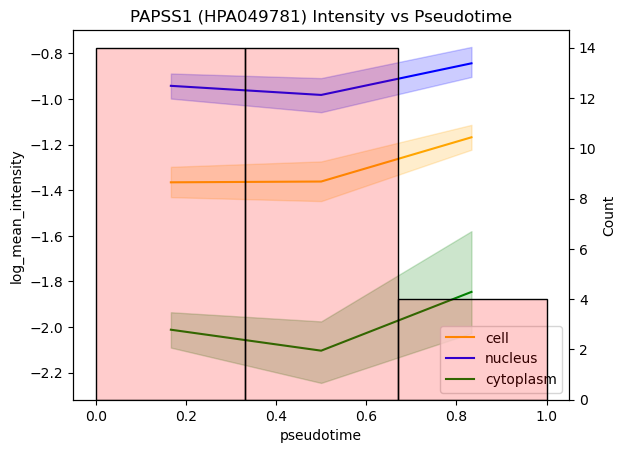

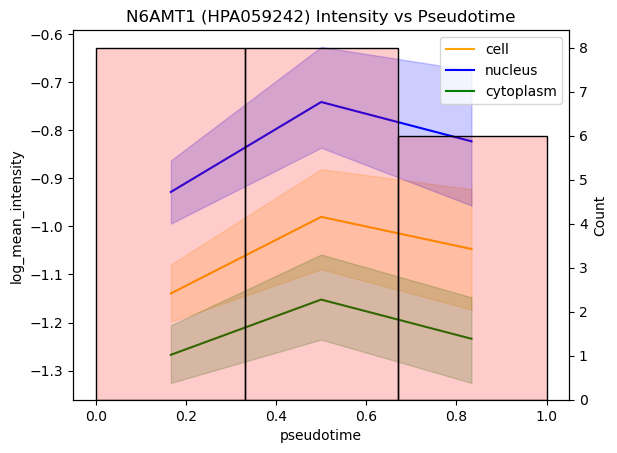

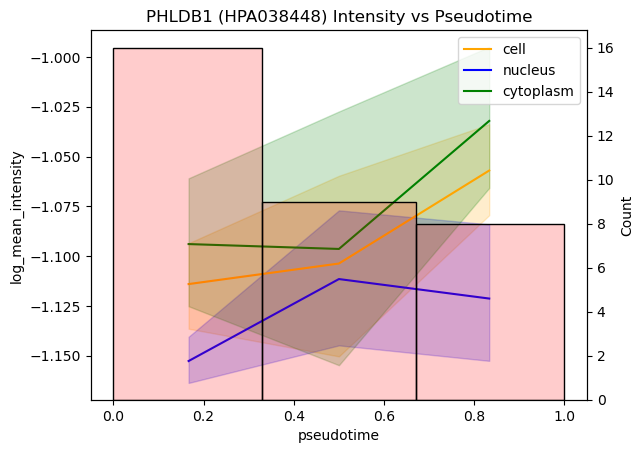

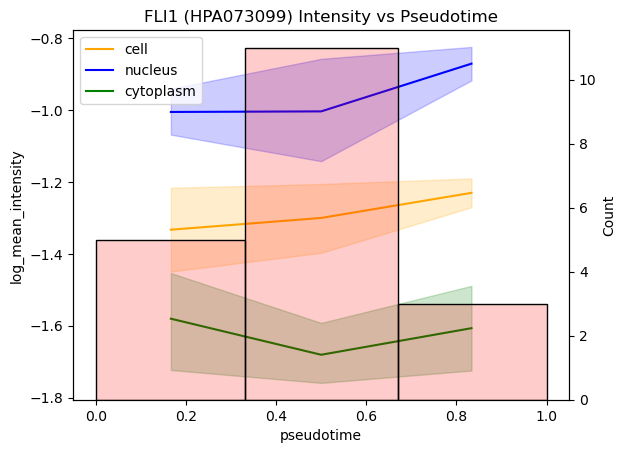

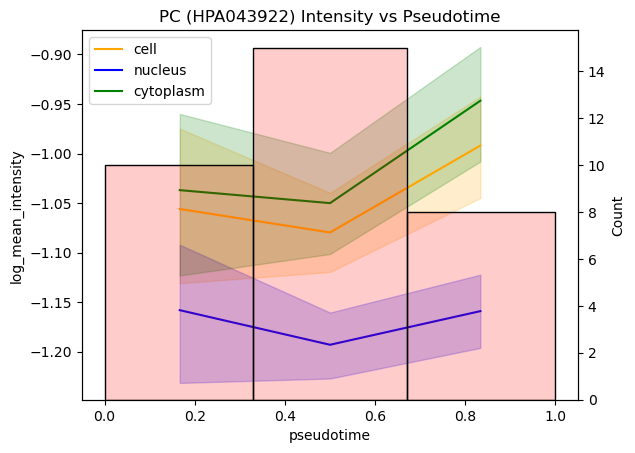

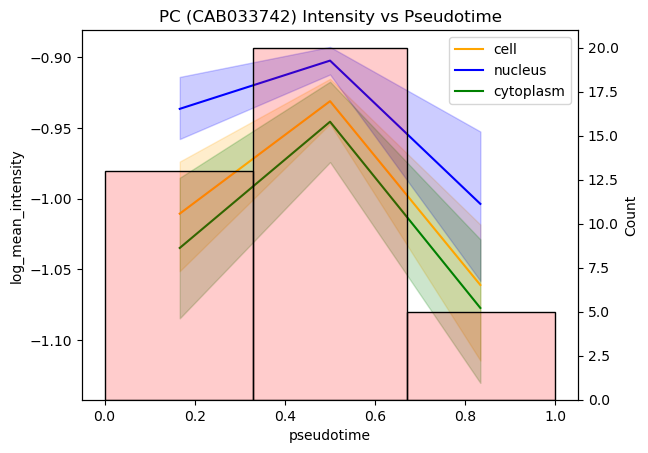

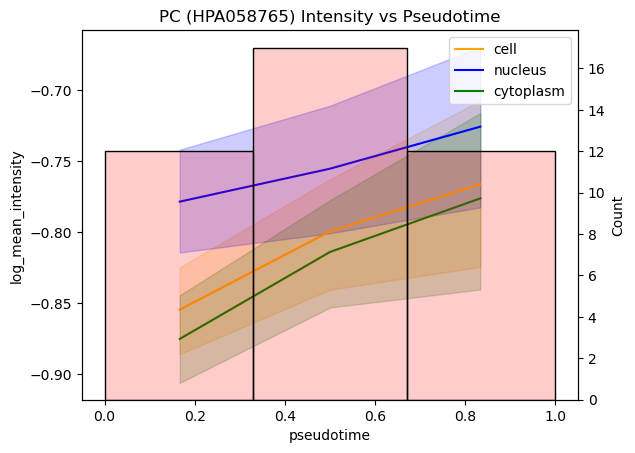

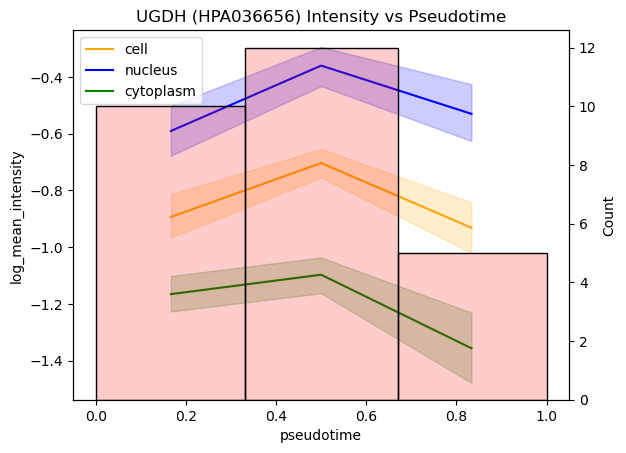

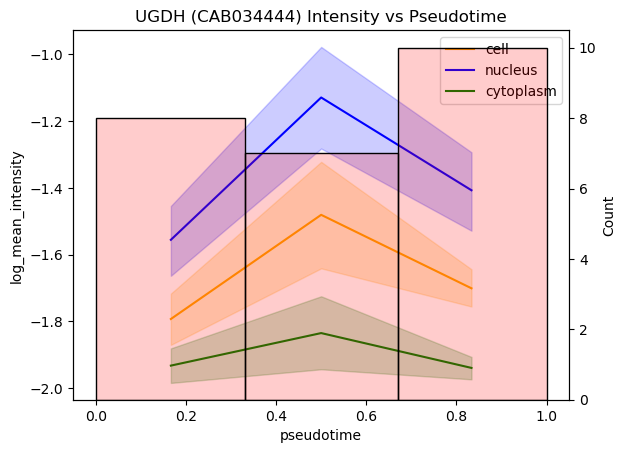

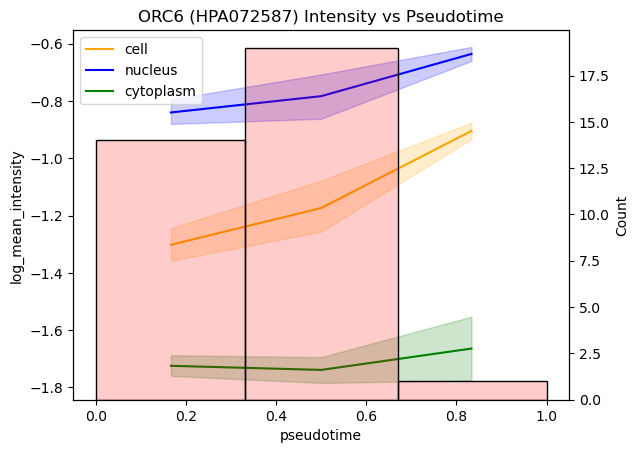

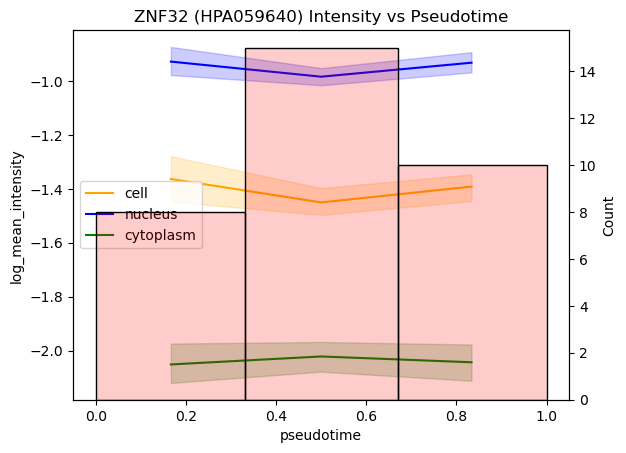

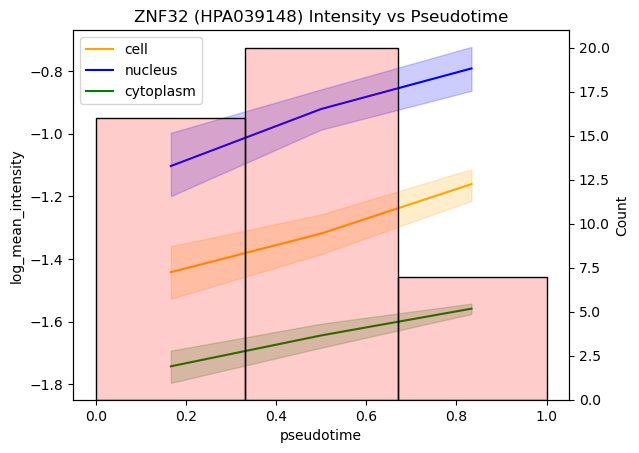

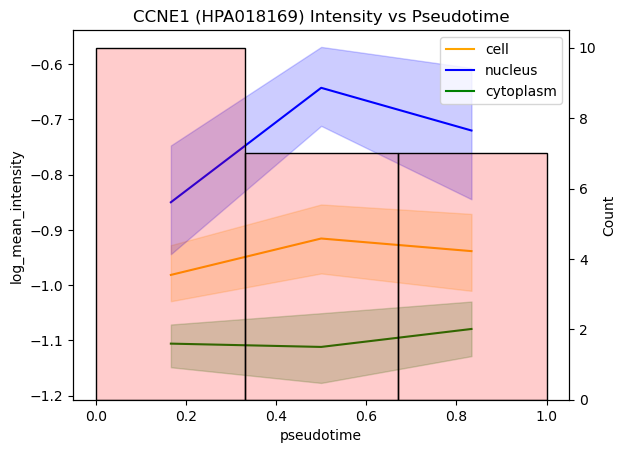

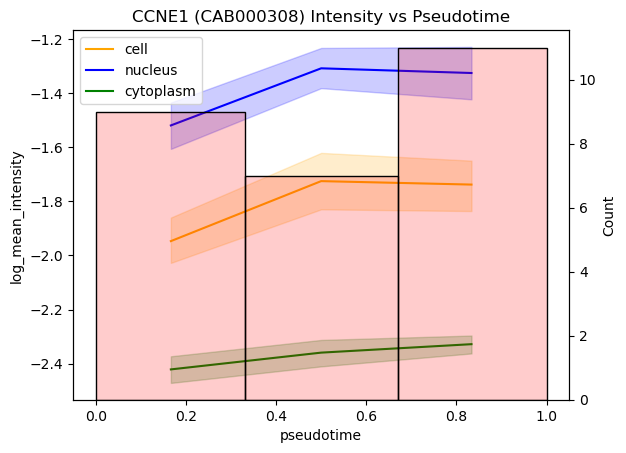

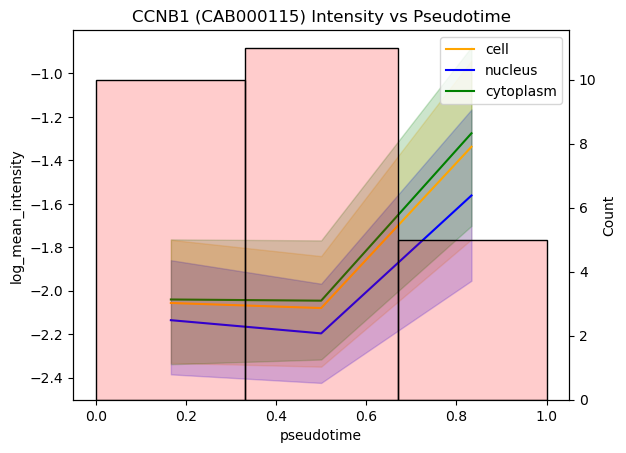

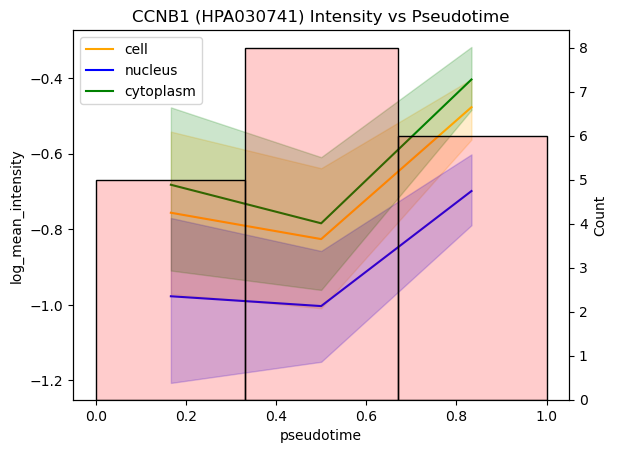

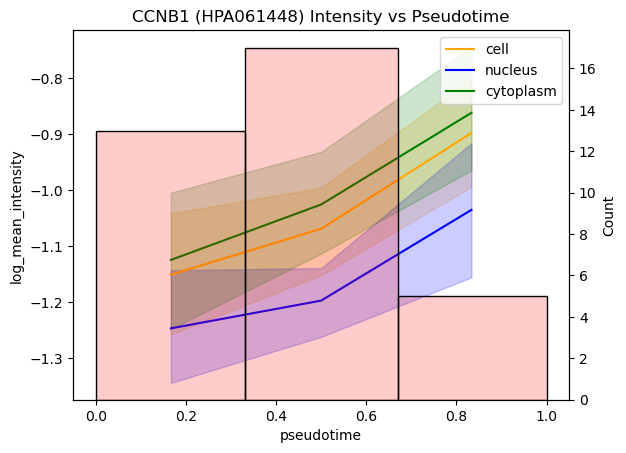

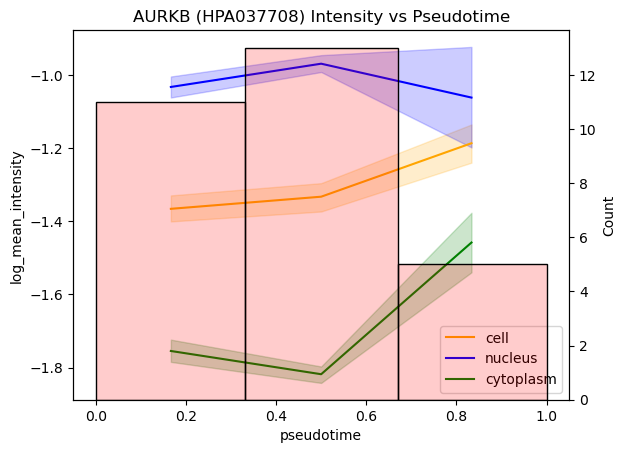

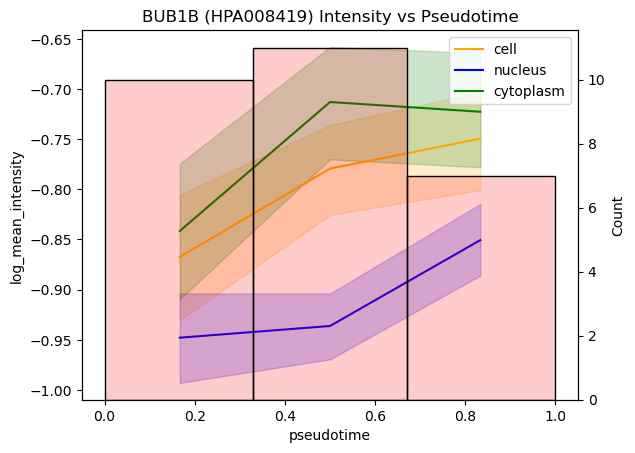

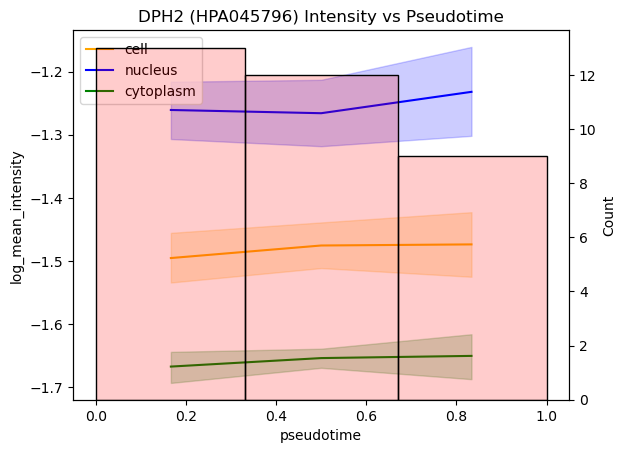

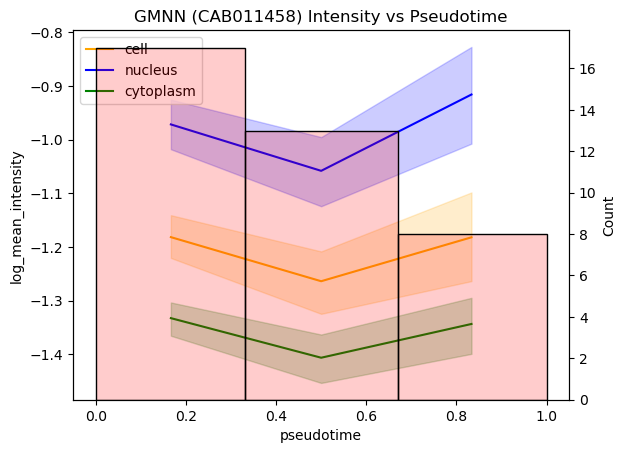

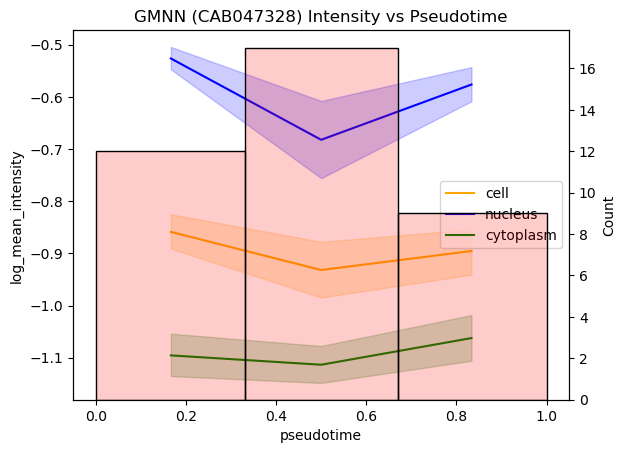

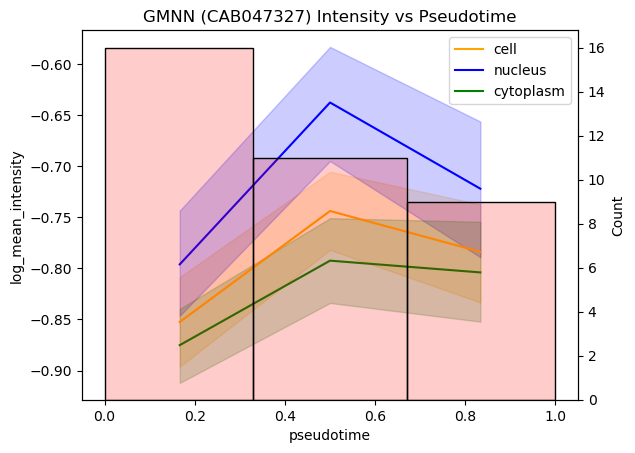

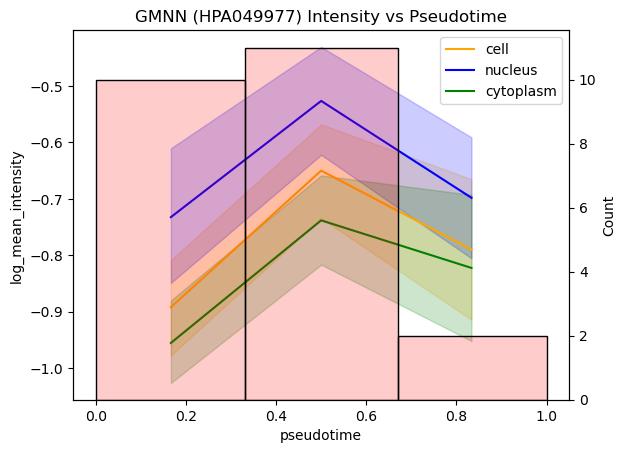

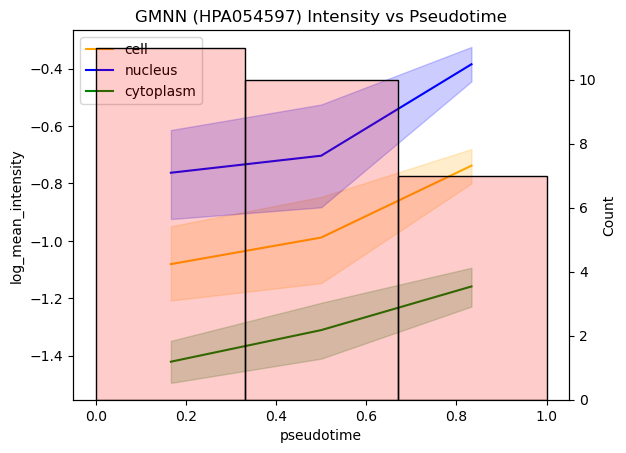

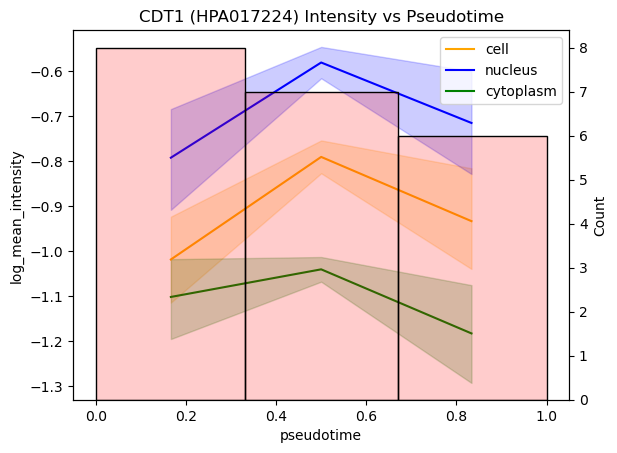

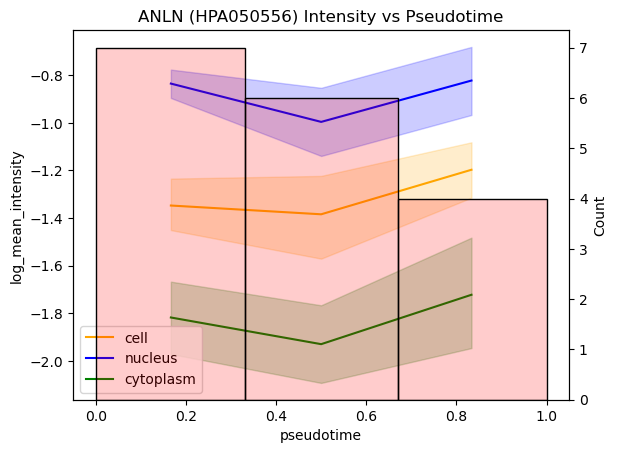

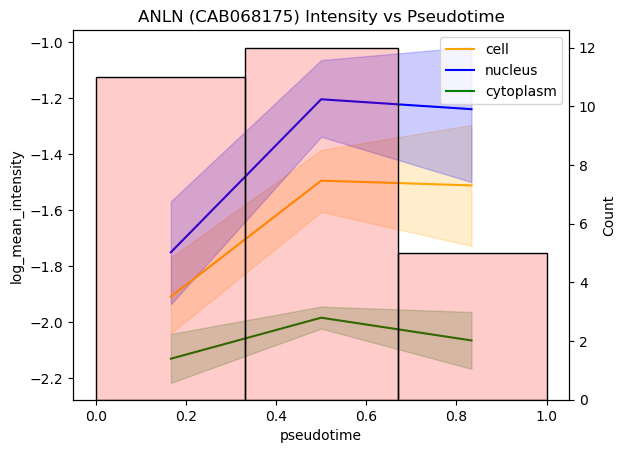

In [8]:
"""
    prot_ant_int_ps[(prot, antibody)] = {
        "pseudotime": pseudotime,
        "intensity_sums": intensity_sums,
        "non_zero_cts": non_zero_cts,
        "log_mean_intensity": log_mean_intensity,
        "log_intensity": log_intensity,
        "mean_intensity": mean_intensity
    }
"""

# original large model on normalized images
# checkpoint_hash = "r2z2n8ap"
# concat = False
# well = False
# chamber and tile trained small model
# checkpoint_hash = "jv6n44jc"
# concat = True
# well = False
# chamber trained small model
# checkpoint_hash = "i2v4ueke"
# concat = True
# well = False
# all trained model, with well intensities and concat
# checkpoint_hash = "on08u1fc"
# concat = True
# well = True
# model trained on tile and chamber
# checkpoint_hash = "24jh7g80"
# checkpoint_hash = "wwzdewqp"
# checkpoint_hash = "nlr3fa5k" # 80/20
# concat = True
# well = True
# model trained only on the chamber dataset
# checkpoint_hash = "222lb9ox"
# checkpoint_hash = "vvepu5m7"
# concat = True
# well = True
# model trained only on the tile dataset
checkpoint_hash = "8ud1u6y4"
concat = True
well = True

cc_paper_prot_ant = {
    "DUSP19": ["HPA021501"],
    "DUSP18": ["HPA051349"],
    "PAPSS1": ["HPA049781"],
    "N6AMT1": ["HPA059242"],
    # "PHLDB1": [""],
    # "FLI1": [""],
    # "TTC21B": [""],
    "PC": ["HPA043922"],
    "UGDH": ["HPA036656"],
    "ORC6": ["HPA072587"],
    "ZNF32": ["HPA039148"],
    "CCNE1": ["HPA018169"],
    "CCNB1": ["HPA051349"],
    "AURKB": ["HPA037708"],
    "BUB1B": ["HPA008419"],
    "DPH2": ["HPA045796"],
    "GMNN": ["HPA054597"],
    # "CDT1": [""],
    "ANLN": ["HPA050556"],
}

prot_img_stats = {}

num_bins = 3
ci = 75

sample_prop = None
filter_prots = False

prot_ant_int_ps = pkl.load(open(DATA_DIR / f"prot_ant_ps_stats_{checkpoint_hash}.pkl", "rb"))

pseudotimes = []
for (prot, antibody), stats in prot_ant_int_ps.items():
    if filter_prots and (prot not in cc_paper_prot_ant):
        continue
    if filter_prots and (antibody not in cc_paper_prot_ant[prot]):
        continue
    pseudotime = stats["pseudotime"].cpu().numpy().flatten()
    intensity = stats["log_mean_intensity"][:, 3].cpu().numpy()
    nuc_intensity = stats["nuc_log_mean_intensity"][:, 3].cpu().numpy()
    cyto_intensity = stats["cyto_log_mean_intensity"][:, 3].cpu().numpy()

    if sample_prop is not None and sample_prop < 1:
        sample_size = int(len(pseudotime) * sample_prop)
        sample = np.random.choice(len(pseudotime), size=sample_size, replace=False)
        pseudotime = pseudotime[sample]
        intensity = intensity[sample]
        nuc_intensity = nuc_intensity[sample]
        cyto_intensity = cyto_intensity[sample]

    pseudotimes.append(pseudotime)

    bins = np.linspace(0, 1, num_bins + 1)
    pseudotime_binned = (np.digitize(pseudotime, bins) - 1) / num_bins
    pseudotime_binned += (1 / num_bins) / 2

    df_dict = {"pseudotime": pseudotime_binned, "log_mean_intensity": intensity,
                "nuc_log_mean_intensity": nuc_intensity, "cyto_log_mean_intensity": cyto_intensity}
    prot_img_stats[(prot, antibody)] = df_dict

    prot_int_df_bin = pd.DataFrame(df_dict)
    df_dict["pseudotime"] = pseudotime
    prot_int_df = pd.DataFrame(df_dict)
    plt.clf()
    sns.lineplot(data=prot_int_df_bin, x="pseudotime", y="log_mean_intensity", errorbar=('ci', ci), label="cell", color='orange')
    sns.lineplot(data=prot_int_df_bin, x="pseudotime", y="nuc_log_mean_intensity", errorbar=('ci', ci), label="nucleus", color='blue')
    ax = sns.lineplot(data=prot_int_df_bin, x="pseudotime", y="cyto_log_mean_intensity", errorbar=('ci', ci), label="cytoplasm", color='green')
    ax2 = ax.twinx()
    sns.histplot(pseudotime, bins=[0, 0.33, 0.67, 1.0], ax=ax2, alpha=0.2, color="red")
    plt.title(f"{prot} ({antibody}) Intensity vs Pseudotime")
    plt.show()

pseudotimes = np.concatenate(pseudotimes)
pkl.dump(prot_img_stats, open(DATA_DIR / f"prot_img_stats_{checkpoint_hash}.pkl", "wb"))

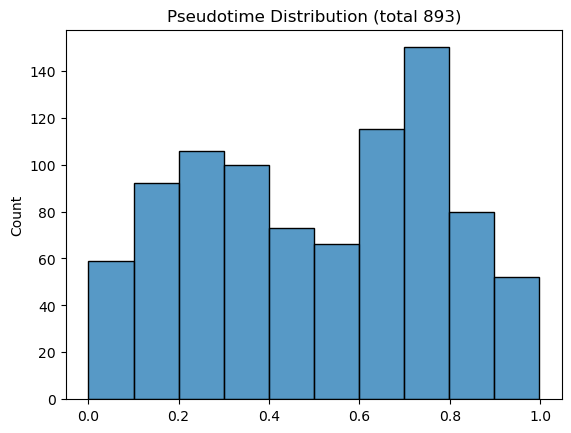

In [9]:
def normalized_to_cc_paper(ps):
    normalized = [0, 0.33, 0.5, 0.67, 1.0]
    hpa = [0, 0.37, 0.6, 0.75, 1.0]
    return np.interp(ps, normalized, hpa)

plt.clf()
sns.histplot(normalized_to_cc_paper(pseudotimes), bins=10)
plt.title(f"Pseudotime Distribution (total {len(pseudotimes)})")
plt.show()

torch.Size([28, 4])


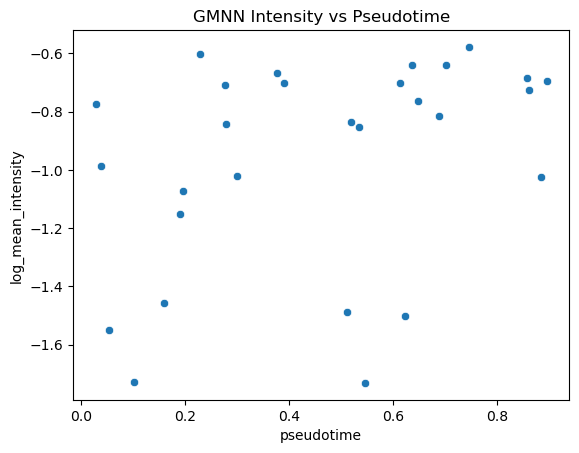

NameError: name 'dataset' is not defined

<Figure size 640x480 with 0 Axes>

In [10]:
prot = "GMNN"
antibody = "HPA054597"

stats = prot_ant_int_ps[(prot, antibody)]
pseudotime = stats["pseudotime"].cpu().numpy().flatten()
log_intensity = stats["log_mean_intensity"]
plot_intensity = log_intensity[:, 3].cpu().numpy()
print(log_intensity.shape)

# plot intensity vs binned pseudotime
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
pseudotime_binned = (np.digitize(pseudotime, bins) - 1) / num_bins

# prot_int_df = pd.DataFrame({"pseudotime": pseudotime_binned, "log_mean_intensity": plot_intensity})
# plt.clf()
# sns.lineplot(data=prot_int_df, x="pseudotime", y="log_mean_intensity", errorbar=('ci', 95))
# plt.title(f"{prot} Intensity vs Pseudotime")
# plt.show()

# randomly sample half of the data and plot the intensity vs binned pseudotime, repeat 10 times
# plt.clf()
# for i in range(10):
#     sample = np.random.choice(len(pseudotime_binned), len(pseudotime_binned) // 2, replace=False)
#     prot_int_df = pd.DataFrame({"pseudotime": pseudotime_binned[sample], "log_mean_intensity": plot_intensity[sample]})
#     prot_int_df = prot_int_df.groupby("pseudotime").mean().reset_index()
#     prot_int_df = prot_int_df.sort_values(by=["pseudotime"])
#     # sns.lineplot(data=prot_int_df, x="pseudotime", y="log_mean_intensity", color="blue", alpha=0.5)
#     plt.plot(prot_int_df["pseudotime"], prot_int_df["log_mean_intensity"], color="blue", alpha=0.5)
# plt.title(f"{prot} Intensity vs Pseudotime")
# plt.show()

prot_int_df = pd.DataFrame({"pseudotime": pseudotime, "log_mean_intensity": plot_intensity})
plt.clf()
sns.scatterplot(data=prot_int_df, x="pseudotime", y="log_mean_intensity")
plt.title(f"{prot} Intensity vs Pseudotime")
plt.show()

# pick a random sample from each pseudotime bin and display the image from the dataset
for i in range(num_bins):
    try:
        sample = np.where(pseudotime_binned == i / num_bins)[0][2]
    except IndexError:
        continue
    plt.clf()
    dapi, tubl, er, anti = dataset[sample]
    print(dapi.shape)
    image = torch.stack([tubl, anti, torch.zeros_like(dapi)], dim=0)
    print(image.shape)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{prot} Pseudotime {i / num_bins}")
    plt.show()

# Intensity Exploration

In [ ]:
eval_percentiles = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 75, 80, 85, 90, 95, 99, 100]
resolution = 8 # bit
buckets = 2 ** resolution
eval_percentiles = np.array(list(range(0, buckets, 1))) / (buckets - 1) * 100

percentiles_path = DATA_DIR / f"well_percentiles_{buckets}.npy"
well_percentiles = np.load(percentiles_path)

FUCCI_DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
# fucci_well_percentiles = np.load(FUCCI_DATA_DIR / f"well_percentiles_{buckets}.npy")
fucci_well_percentiles = np.load(FUCCI_DATA_DIR / "normalized_well_percentiles.npy")

well_percentiles = well_percentiles[:, 2:]
fucci_well_percentiles = fucci_well_percentiles[:, 2:]

30


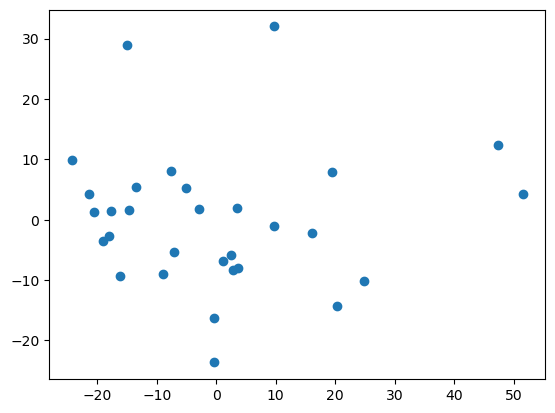

Explained variance ratio: [6.75316072e-01 2.55336769e-01 2.33068566e-02 1.69020980e-02
 8.82111405e-03 6.67271895e-03 4.22446259e-03 2.76509383e-03
 2.11688863e-03 1.62139710e-03 1.06710750e-03 7.97034657e-04
 3.30556010e-04 2.86116972e-04 1.69946701e-04]


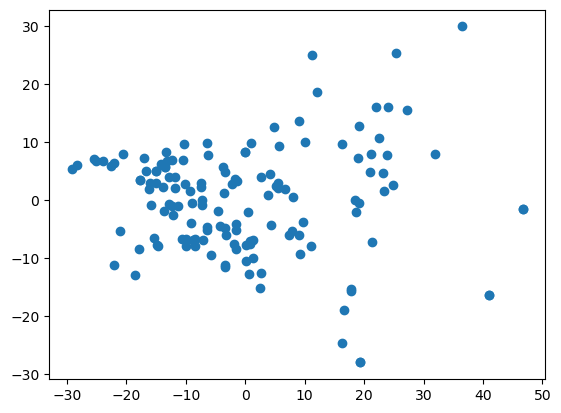

Explained variance ratio: [0.498168   0.1727963  0.11320157 0.04889305 0.04444931 0.03050339
 0.02028004 0.01287781 0.00994174 0.00743589 0.00578768 0.00483992
 0.00449109 0.00309951 0.00253694]


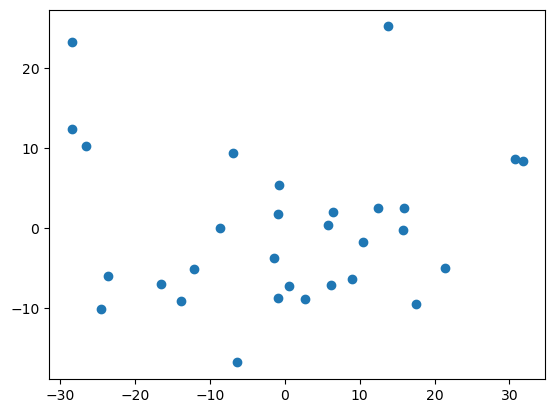

Explained variance ratio: [0.53498232 0.17931084 0.11511076 0.04941663 0.03918168 0.03138834
 0.01602875 0.00852051 0.00624892 0.00514473 0.00397136 0.00293102
 0.00195154 0.00163607 0.00101656]


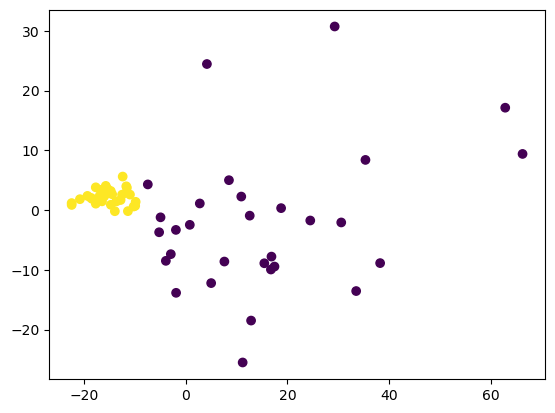

Explained variance ratio: [7.87728365e-01 1.43625944e-01 2.95600068e-02 1.45630873e-02
 6.81293043e-03 4.01356203e-03 2.93835755e-03 2.70740504e-03
 2.09204055e-03 1.61969786e-03 1.34341104e-03 1.18898184e-03
 4.84992836e-04 3.56744703e-04 2.16018855e-04]


(PCA(n_components=15), StandardScaler())

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def percentiles_PCA(well_percentiles, color=None):
    well_percentiles = well_percentiles.reshape(well_percentiles.shape[0], -1) # W x (C * P)
    scaler = StandardScaler()
    scaled_well_percentiles = scaler.fit_transform(well_percentiles)
    pca = PCA(n_components=15)
    well_pca = pca.fit_transform(scaled_well_percentiles)
    plt.clf()
    if color is None:
        plt.scatter(well_pca[:, 0], well_pca[:, 1])
    else:
        plt.scatter(well_pca[:, 0], well_pca[:, 1], c=color)
    plt.show()

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pca, scaler

fucci_well_samples = np.random.choice(len(fucci_well_percentiles), len(well_percentiles), replace=False)
# fucci_well_samples = np.arange(len(fucci_well_percentiles))
colors = [0] * len(well_percentiles) + [1] * len(fucci_well_samples)
print(len(fucci_well_samples))
percentiles_PCA(well_percentiles)
percentiles_PCA(fucci_well_percentiles)
percentiles_PCA(fucci_well_percentiles[fucci_well_samples])
percentiles_PCA(np.concatenate([well_percentiles, fucci_well_percentiles[fucci_well_samples]], axis=0), color=colors)

# CLS Exploration

In [ ]:
hpa_cls_tokens = torch.load(DATA_DIR / f"ref_cls_tokens_{checkpoint_hash}.pt")

In [ ]:
FUCCI_DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
FUCCI_NAME = "well_spline_norm_512_crop_sharpness_1250"
fucci_dataset = CellImageDataset(FUCCI_DATA_DIR / f"index_{FUCCI_NAME}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_red", "pure_green"], batch_size=batch_size)
fucci_cls_tokens = dino.predict_cls(fucci_dataset).detach().cpu()

Loading dataset images: 100%|██████████| 5/5 [01:46<00:00, 21.24s/it]


Loaded 33933 images from 142 files.


AttributeError: 'HPA_DINO' object has no attribute 'predict_cls'

In [ ]:
# load the pseudotime predictions for the HPA images and the FUCCI images
hpa_pseudotimes = []
for (prot, antibody), stats in prot_ant_int_ps.items():
    pseudotime = stats["pseudotime"].cpu().numpy().flatten()
    hpa_pseudotimes.append(pseudotime)

hpa_pseudotimes = np.concatenate(hpa_pseudotimes)

fucci_pseudotimes_labels = np.load(FUCCI_DATA_DIR / f"FUCCI_pseudotime_{FUCCI_NAME}.npy")
fucci_pseudotimes_preds = np.load(FUCCI_DATA_DIR / f"FUCCI_pseudotime_pred_{FUCCI_NAME}.npy")

(906,) float64
(906,) float64
(906,) float64
906 906
True


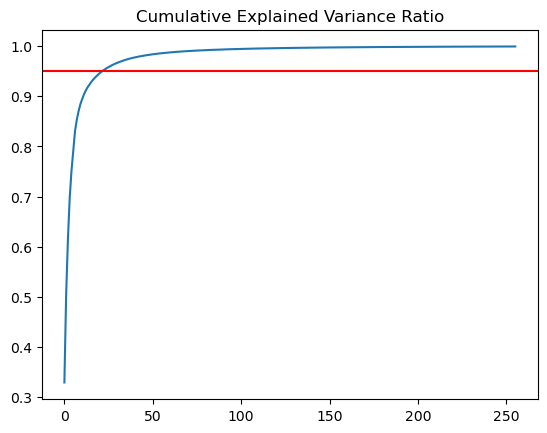

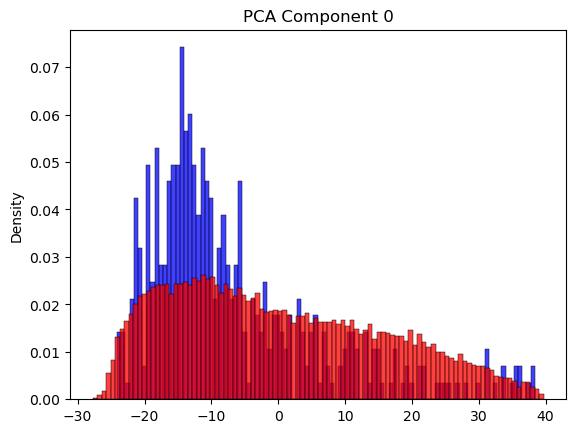

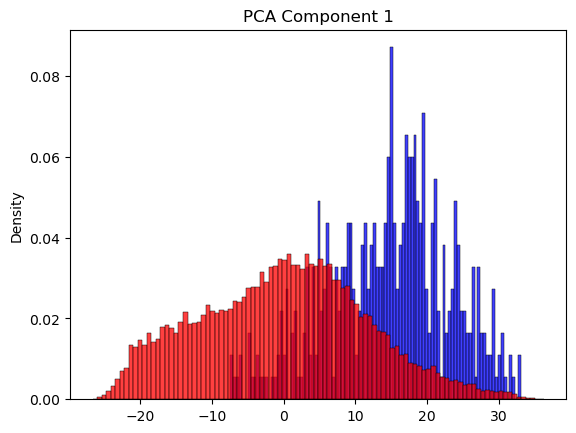

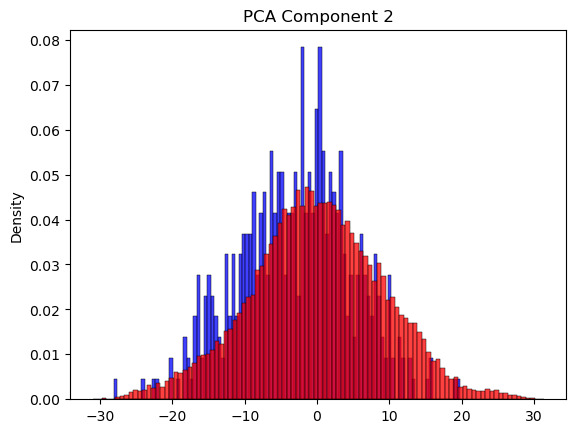

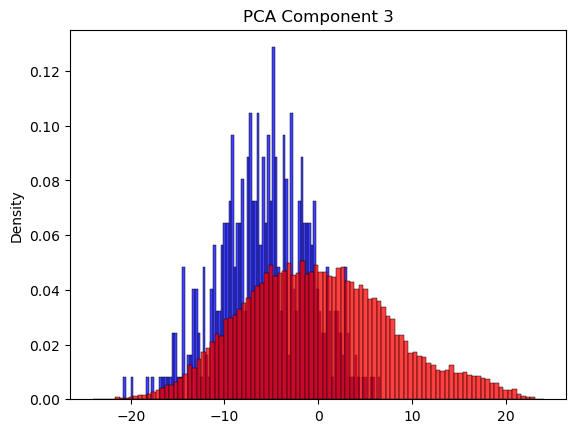

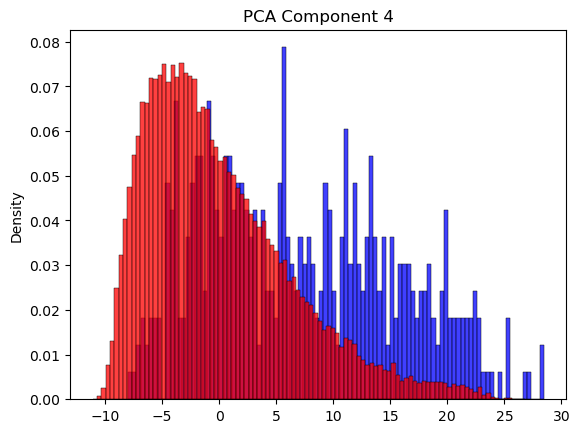

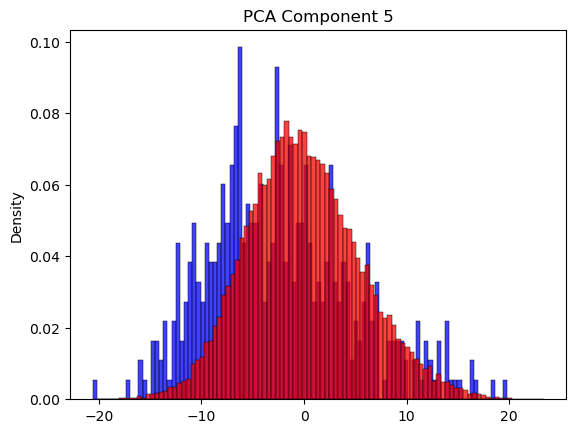

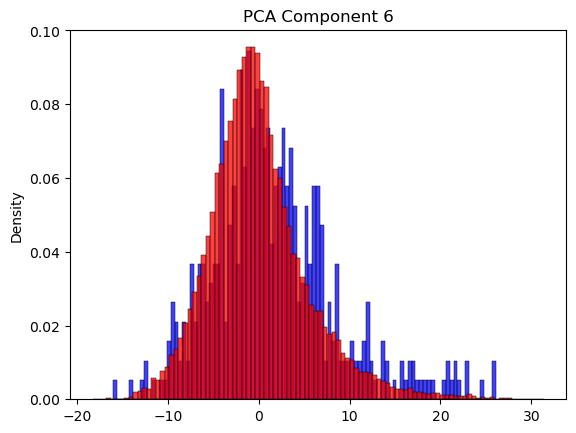

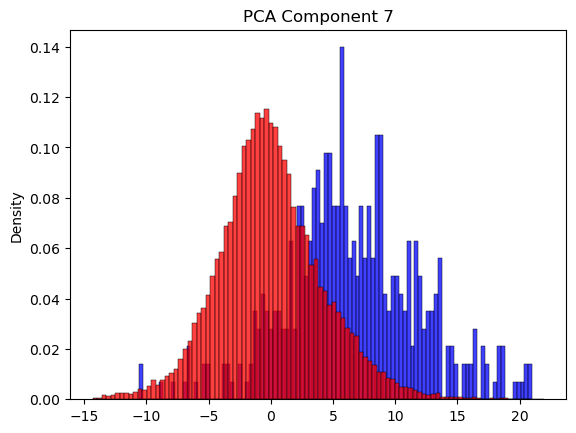

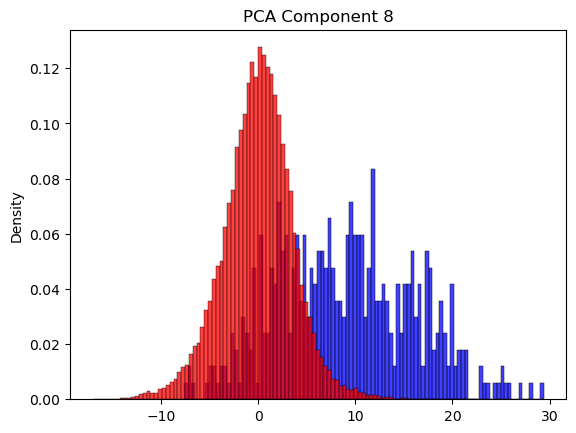

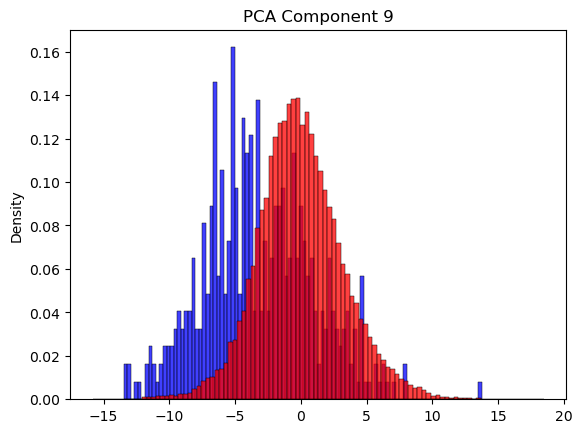

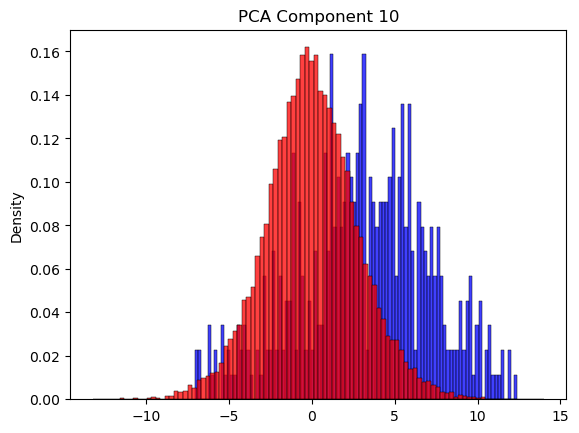

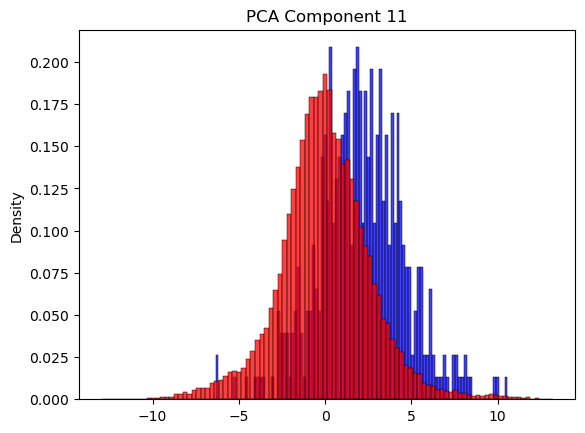

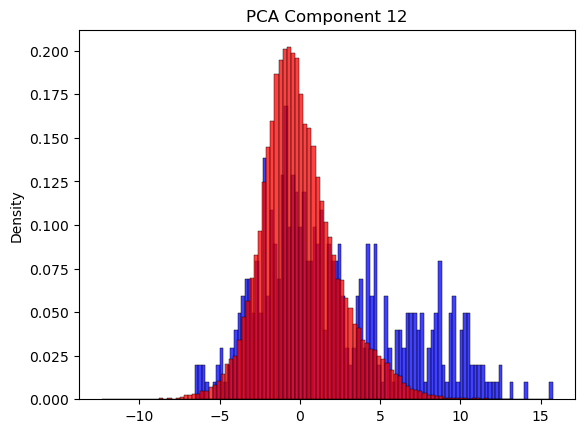

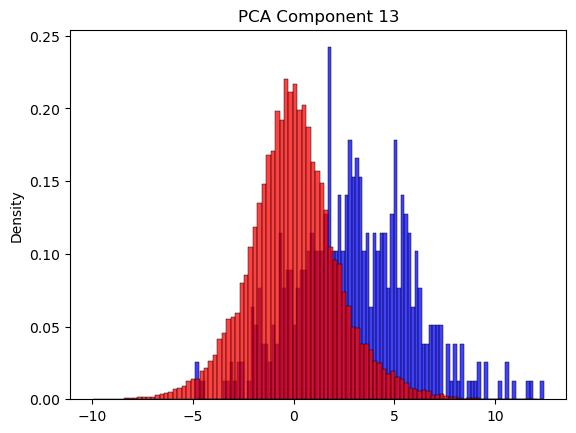

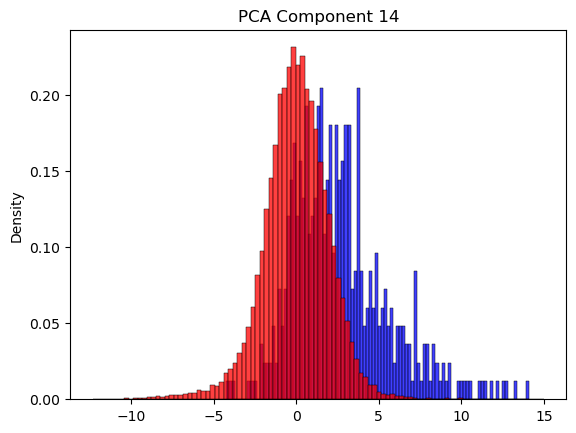

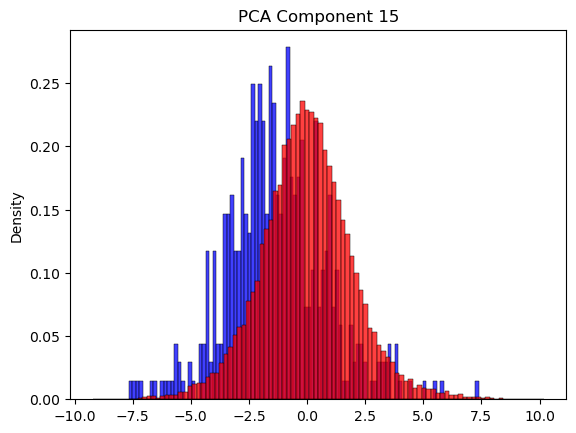

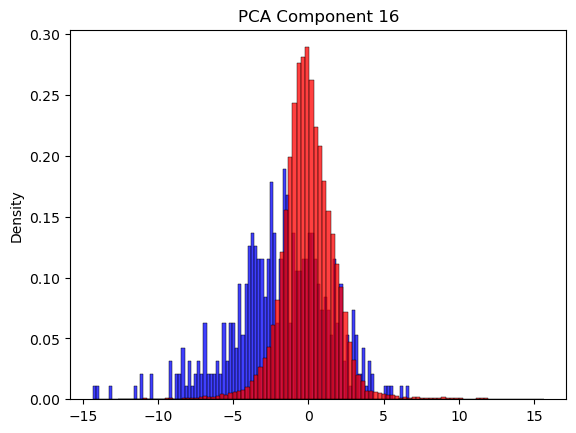

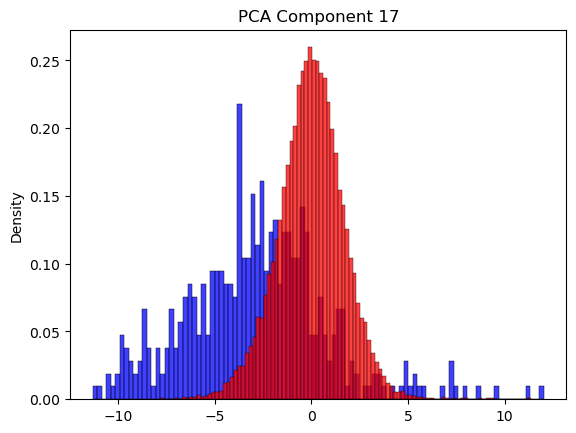

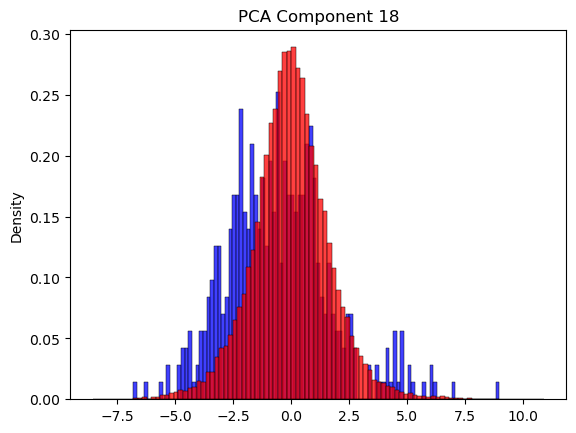

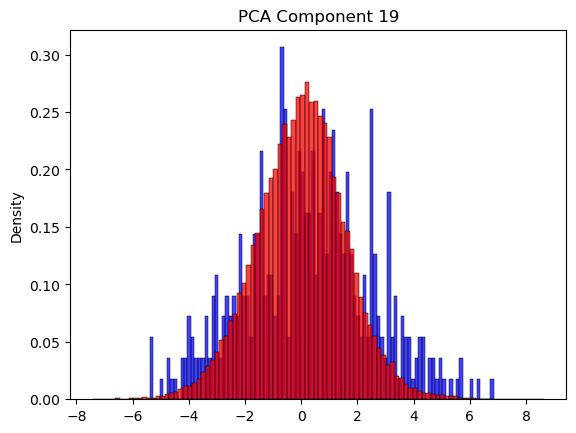

In [ ]:
# PCA of the two groups of cls tokens, colored by the source
colors = [0] * len(hpa_cls_tokens) + [1] * len(fucci_cls_tokens)
cls_tokens = torch.cat([hpa_cls_tokens, fucci_cls_tokens], dim=0)

scaler = StandardScaler()
pca = PCA(n_components=256)

scaler.fit(cls_tokens[len(hpa_cls_tokens):])
scaled_cls_tokens = scaler.transform(cls_tokens)

pca.fit(scaled_cls_tokens[len(hpa_cls_tokens):])
cls_pca = pca.transform(scaled_cls_tokens)

print(cls_pca[:len(hpa_cls_tokens), 0].shape, cls_pca[:len(hpa_cls_tokens), 0].dtype)
print(cls_pca[:len(hpa_cls_tokens), 1].shape, cls_pca[:len(hpa_cls_tokens), 1].dtype)
print(hpa_pseudotimes.shape, hpa_pseudotimes.astype('float64').dtype)
print(len(np.ma.ravel(hpa_pseudotimes)), cls_pca[:len(hpa_cls_tokens), 0].size)
print(np.issubdtype(hpa_pseudotimes.dtype, np.floating))


# cdf of explained variance ratio
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio")
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

# plot normalized histograms for the two groups of cls tokens for the first 20 components
for i in range(20):
    plt.clf()
    sns.histplot(cls_pca[:len(hpa_cls_tokens), i], bins=100, color="blue", label="HPA", stat="density")
    sns.histplot(cls_pca[len(hpa_cls_tokens):, i], bins=100, color="red", label="FUCCI", stat="density")
    plt.title(f"PCA Component {i}")
    plt.show()

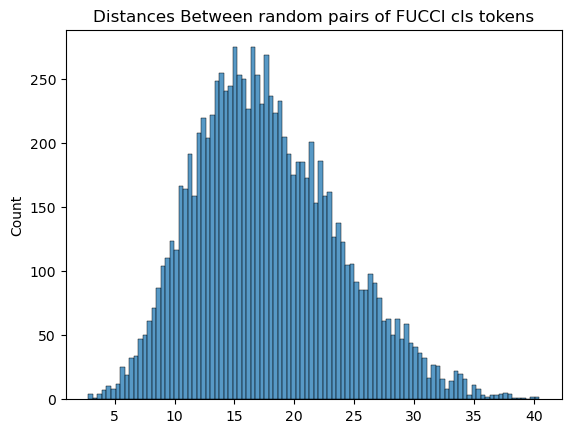

In [ ]:
# plot the distribution of distances between cls tokens from the FUCCI dataset
sample_size = 10000
sample_left = np.random.choice(len(fucci_cls_tokens), sample_size, replace=False)
sample_right = np.random.choice(len(fucci_cls_tokens), sample_size, replace=False)
sample_left = fucci_cls_tokens[sample_left]
sample_right = fucci_cls_tokens[sample_right]
distances = torch.norm(sample_left - sample_right, dim=1)

plt.clf()
sns.histplot(distances, bins=100)
plt.title("Distances Between random pairs of FUCCI cls tokens")
plt.show()

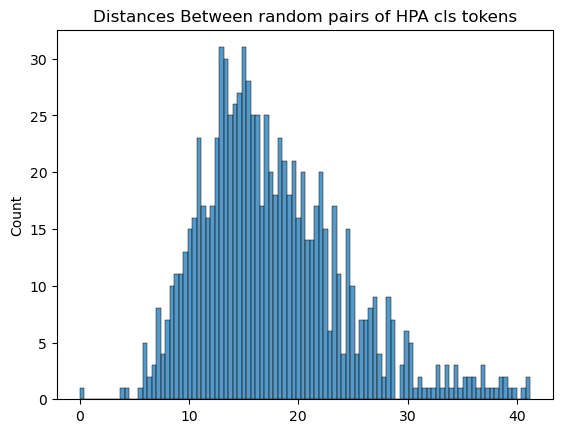

In [ ]:
# plot the distribution of distances between cls tokens from the HPA dataset
sample_size = len(hpa_cls_tokens)
sample_left = np.random.choice(len(hpa_cls_tokens), sample_size, replace=False)
sample_right = np.random.choice(len(hpa_cls_tokens), sample_size, replace=False)
sample_left = hpa_cls_tokens[sample_left]
sample_right = hpa_cls_tokens[sample_right]
distances = torch.norm(sample_left - sample_right, dim=1)

plt.clf()
sns.histplot(distances, bins=100)
plt.title("Distances Between random pairs of HPA cls tokens")
plt.show()

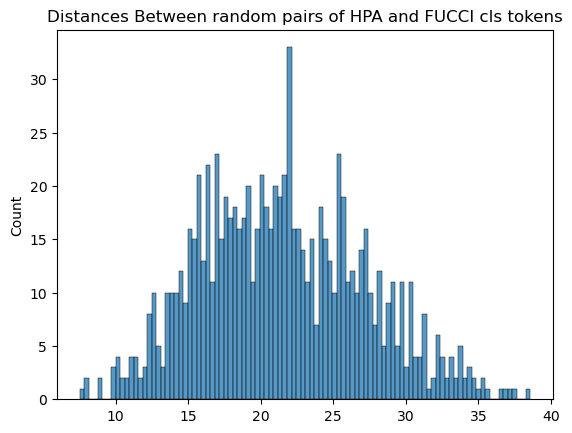

In [ ]:
# plot the distribution of distances between cls tokens from the HPA and FUCCI datasets
sample_size = len(hpa_cls_tokens)
sample_left = np.random.choice(len(hpa_cls_tokens), sample_size, replace=False)
sample_right = np.random.choice(len(fucci_cls_tokens), sample_size, replace=False)
sample_left = hpa_cls_tokens[sample_left]
sample_right = fucci_cls_tokens[sample_right]
distances = torch.norm(sample_left - sample_right, dim=1)

plt.clf()
sns.histplot(distances, bins=100)
plt.title("Distances Between random pairs of HPA and FUCCI cls tokens")
plt.show()

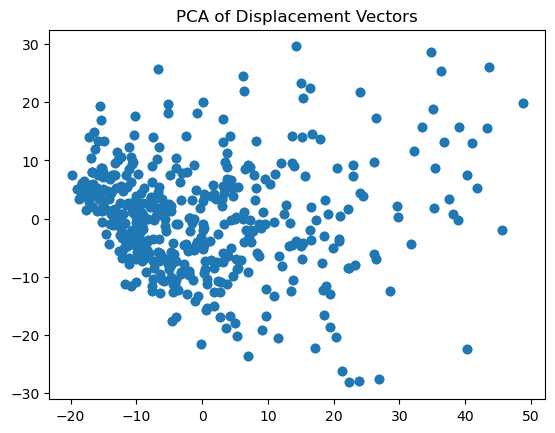

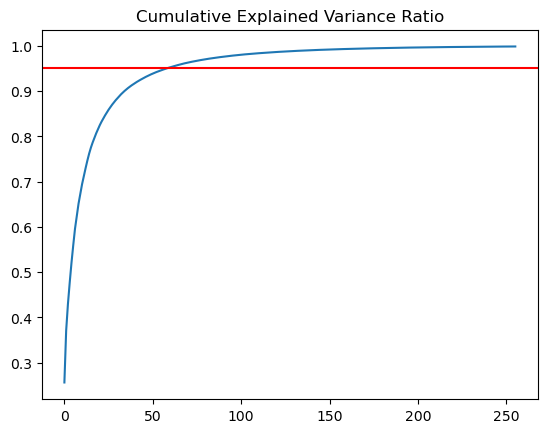

In [ ]:
# find the nearest neighbor of each HPA cls token in the FUCCI cls tokens and plot the PCA of the displacement vectors
from sklearn.neighbors import NearestNeighbors
n_neighbors = 20
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(fucci_cls_tokens)
distances, indices = nbrs.kneighbors(hpa_cls_tokens)

displacement = fucci_cls_tokens[indices] - hpa_cls_tokens[:, None]
displacement = torch.mean(displacement, dim=1)
scaler = StandardScaler()
pca = PCA(n_components=256)
displacement = scaler.fit_transform(displacement)
displacement = pca.fit_transform(displacement)

plt.clf()
plt.scatter(displacement[:, 0], displacement[:, 1])
plt.title("PCA of Displacement Vectors")
plt.show()

# plot the cumulative explained variance ratio
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio")
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()


In [ ]:
fucci_sample = np.random.choice(len(fucci_cls_tokens), len(fucci_cls_tokens) // 2, replace=False)
fucci_rest = np.setdiff1d(np.arange(len(fucci_cls_tokens)), fucci_sample)
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(fucci_cls_tokens[fucci_sample])
distances, fucci_indices = nbrs.kneighbors(fucci_cls_tokens[fucci_rest])
distances, hpa_indices = nbrs.kneighbors(hpa_cls_tokens)

fucci_displacement = fucci_cls_tokens[fucci_indices] - fucci_cls_tokens[fucci_rest][:, None]
fucci_displacement = torch.mean(fucci_displacement, dim=1)
scaler = StandardScaler()
pca = PCA(n_components=256)
fucci_displacement = scaler.fit_transform(fucci_displacement)
fucci_displacement = pca.fit_transform(fucci_displacement)

hpa_displacement = fucci_cls_tokens[hpa_indices] - hpa_cls_tokens[:, None]
hpa_displacement = torch.mean(hpa_displacement, dim=1)
hpa_displacement = scaler.transform(hpa_displacement)
hpa_displacement = pca.transform(hpa_displacement)

plt.clf()
plt.scatter(fucci_displacement[:, 0], fucci_displacement[:, 1], color="red", label="FUCCI", alpha=0.2)
plt.scatter(hpa_displacement[:, 0], hpa_displacement[:, 1], color="blue", label="HPA", alpha=0.2)
plt.title("PCA of Displacement Vectors")
plt.legend()
plt.show()

# plot the cumulative explained variance ratio
plt.clf()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance Ratio")
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

# plot the histograms for each for the first 10 components
for i in range(10):
    plt.clf()
    sns.histplot(fucci_displacement[:, i], bins=100, color="red", label="FUCCI", stat="density")
    sns.histplot(hpa_displacement[:, i], bins=100, color="blue", label="HPA", stat="density")
    plt.title(f"PCA Component {i}")
    plt.show()

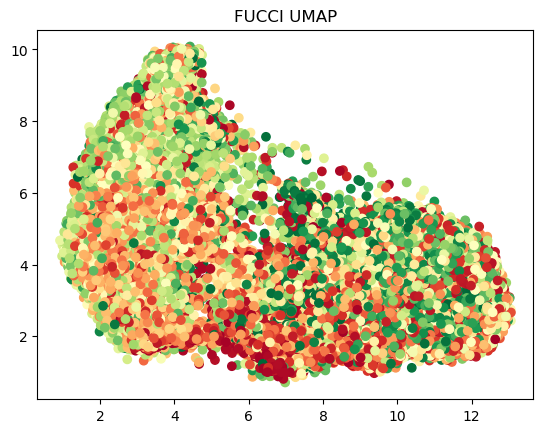

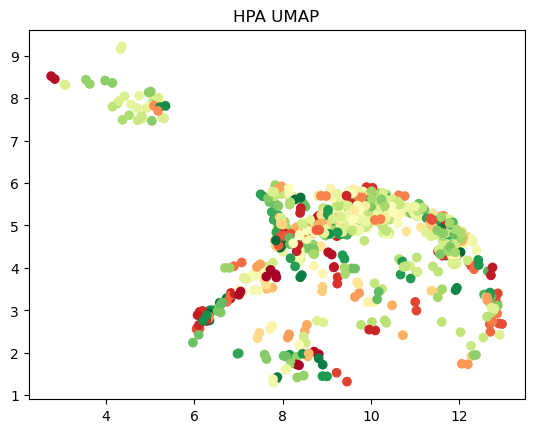

In [ ]:
# plot umaps of the two groups of cls tokens, colored by the source
# plot both using the umap transformation of the FUCCI data

import umap

reducer = umap.UMAP()
sample = np.random.choice(len(fucci_cls_tokens), 1000, replace=False) + len(hpa_cls_tokens)
reducer.fit(scaled_cls_tokens[sample])
fucci_umap = reducer.transform(scaled_cls_tokens[len(hpa_cls_tokens):])

plt.clf()
plt.scatter(fucci_umap[:, 0], fucci_umap[:, 1], c=fucci_pseudotimes_labels, cmap="RdYlGn")
plt.title("FUCCI UMAP")
plt.show()

hpa_umap = reducer.transform(scaled_cls_tokens[:len(hpa_cls_tokens)])

plt.clf()
plt.scatter(hpa_umap[:, 0], hpa_umap[:, 1], c=hpa_pseudotimes, cmap="RdYlGn")
plt.title("HPA UMAP")
plt.show()

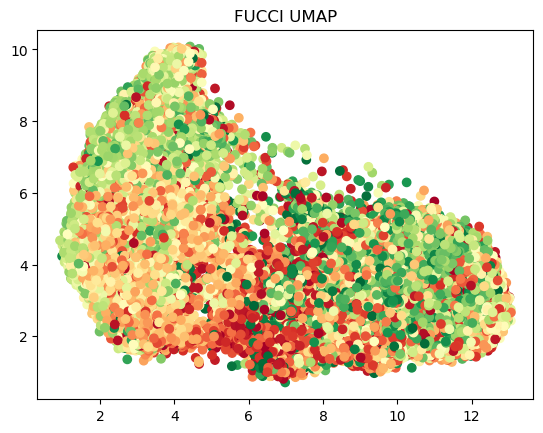

In [ ]:
plt.clf()
plt.scatter(fucci_umap[:, 0], fucci_umap[:, 1], c=fucci_pseudotimes_preds, cmap="RdYlGn")
plt.title("FUCCI UMAP")
plt.show()